# Section 1: Images

In [140]:
from glob import glob
from multiprocessing import Pool

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
imshow = plt.imshow
imshow_gray = lambda image: plt.imshow(image, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
import cv2
import numpy as np
import pandas as pd
from PIL import Image

In [141]:
images_path = {}
fonts = ["ruqa", "nask"] # "kufi"
for name in fonts:
    images_path[name] = glob(f"real_images/{name}/*")
    
images = {}
for path in fonts:
    list_images = [cv2.imread(path) for path in images_path[path]]
    images[path] = np.array(list_images)

In [157]:
def filter_white_rows(image: np.ndarray) -> np.ndarray:
    black_lines = []
    for row in image:
        for pixel in row:
            if (pixel != [255, 255, 255]).any():
                black_lines.append(True)
                break
        else:
            black_lines.append(False)
    return image[black_lines]

def filter_white_cols(image: np.ndarray) -> np.ndarray:
    black_cols = []
    image = np.swapaxes(image, 0, 1)
    for col in image:
        for pixel in col:
            if (pixel != [255, 255, 255]).any():
                black_cols.append(True)
                break
        else:
            black_cols.append(False)
    return np.swapaxes(image[black_cols], 0, 1)

def filter_white_rows_and_cols(image: np.ndarray) -> np.ndarray:
    return filter_white_cols(filter_white_rows(image))

def cut_image(image: np.ndarray, font_type: str, final_width, final_height) -> list:
    """Takes in image and cuts it to rows according to font_type and filters white rows and cols for each image and resizes it to (WIDTH, 100)"""
#     CUTS = {"kufi" : 217 , "nask" : 165 , "ruqa" : 225}
#     font_type_to_line = {"kufi": 7, "nask": 9, "ruqa": 7}
    HEIGHT, WIDTH, *_ = image.shape
    cut = 400 #CUTS[font_type]
    lines = 3 #font_type_to_line[font_type]
    
    rows = []
    for i in range(lines):
        row = image[cut * i:cut * (i+1) , 0:]
        row = filter_white_rows_and_cols(row)
        row = cv2.resize(row, dsize=(WIDTH, final_height), interpolation=cv2.INTER_NEAREST)
        rows.append(row)
        
    final_images = []
    for row in rows:
        for i in range(WIDTH // final_width):
            final_images.append(row[:, i * final_width:(i+1) * final_width])
    
    return final_images

In [158]:
# image = (images["ruqa"][81])
# HEIGHT, WIDTH, *_ = image.shape
# final_width, final_height = 500, 500
# cut = 400
# lines = 4

# rows = []
# for i in range(lines):
#     row = image[cut * i:cut * (i+1) , 0:]
#     row = filter_white_rows_and_cols(row)
#     row = cv2.resize(row, dsize=(WIDTH, final_height), interpolation=cv2.INTER_NEAREST)
#     rows.append(row)

# final_images = []
# for row in rows:
#     for i in range(WIDTH // final_width):
#         final_images.append(row[:, i * final_width:(i+1) * final_width])
        
# imshow(final_images[0])

In [159]:
# Process all photos
for font, font_images in images.items():
    for i, image in enumerate(font_images[:-1]):
        for j, final_image in enumerate(cut_image(image, font, final_width=500, final_height=500)):
            cv2.imwrite(f"data/{font}/{i+1}_{j+1}.png", final_image)

# Section 2: Model

In [1]:
import os
from glob import glob

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
imshow = plt.imshow
imshow_gray = lambda image: plt.imshow(image, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# Helper functions
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = torchvision.transforms.functional.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        
        
def imshow_gray(batch):
    plt.imshow(np.squeeze(batch[0][0]), cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
    
    
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    
    with torch.no_grad():
        for x, y in loader:
            x = x.cuda()
            y = y.cuda()
            
            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
        
        print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}') 
    
    model.train()

    
def predict(img, model, transform=None):
    if transform:
        img = transform(img)
        img = torch.unsqueeze(img, 0)
    _, predictions = torch.max(model(img.cuda()), 1)
    
    class_preds = []
    for pred in predictions:
        class_preds.append(classes[pred])
    return class_preds


def add_preds_to_images(images, labels, preds):
    new_images = []
    for img, label, pred in zip(images, labels, preds):
        img = np.ascontiguousarray(img)
        img = np.squeeze(img)
        img = cv2.putText(img, f"Real: {label}", org=(0, 12), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=(0, 50, 0), thickness=1, lineType=2)
        img = cv2.putText(img, f"Pred: {pred}", org=(0, 25), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=(0, 0, 50), thickness=1, lineType=3)
        new_images.append(torch.unsqueeze(torch.from_numpy(img), 0))
    return torch.stack(new_images)


def calc(inp, kernel_size, padding, stride):
    """ Calculates outputs size of conv layer"""
    return (inp + 2 * padding - (kernel_size - 1) - 1) // stride + 1

In [3]:
num_examples = len(glob("data/**/*"))
width = 200
train, validation, test = int(num_examples * 0.85), int(num_examples * 0.1), int(num_examples * 0.05)
test += num_examples - (train + validation + test) # Deals with rounding errors
batch_size = 32
classes = ("nask", "ruqa")

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Grayscale(num_output_channels=1),
     transforms.Resize((width, width)),
    ])

train_transform = transforms.Compose([
                                    transform,
                                    transforms.GaussianBlur(11),
                                    transforms.RandomPerspective(distortion_scale=0.1, p=0.5),
                                    transforms.RandomAffine(degrees=(-5, 5), translate=(0, 0.05), scale=(0.95, 1.05))
                                ])

dataset = torchvision.datasets.ImageFolder("data", transform=transform)
_, valid_set, test_set = torch.utils.data.random_split(dataset, [train, validation, test])

dataset_train = torchvision.datasets.ImageFolder("data", transform=train_transform)
train_set, *_ = torch.utils.data.random_split(dataset_train, [train, validation, test])


train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
validation_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

In [9]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # 1 * 100 * 100
        # 10 * 50 * 50
        # 30 * 10 * 10
        self.conv1 = nn.Conv2d(1, 10, kernel_size=3, padding=1)  
        self.conv2 = nn.Conv2d(10, 30, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(30, 50, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(50, 70, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2)
        
        self.fc1 = nn.Linear(70 * 11 * 11, 437) 
        self.fc2 = nn.Linear(437, 109)
        self.fc3 = nn.Linear(109, 50)
        self.fc4 = nn.Linear(50, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

    
model = Net().cuda()

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003)

In [7]:
epochs = 10

for epoch in range(epochs):  # loop over the dataset multiple times
    model.train()
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.cuda()
        
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels.cuda())
        loss.backward()
        optimizer.step()
        
    model.eval()
    count = 1
    running_loss = 0.0
    for i, data in enumerate(validation_loader, 0):
        inputs, labels = data
        inputs = inputs.cuda()
        
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels.cuda())
        loss.backward()

        running_loss += loss.item()
        count += 1
    print(f"Epoch: {epoch+1}. Loss: {running_loss / count}")
        

C:\Softwarez\Anaconda\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 1. Loss: 0.5716543793678284
Epoch: 2. Loss: 0.46415549847814774
Epoch: 3. Loss: 0.37448212173249984
Epoch: 4. Loss: 0.09905737555689281
Epoch: 5. Loss: 0.18988226561082733
Epoch: 6. Loss: 0.2646206816037496
Epoch: 7. Loss: 0.0060283962003369294
Epoch: 8. Loss: 0.022043514815676544
Epoch: 9. Loss: 0.0010727404151111841
Epoch: 10. Loss: 0.06973964914989968


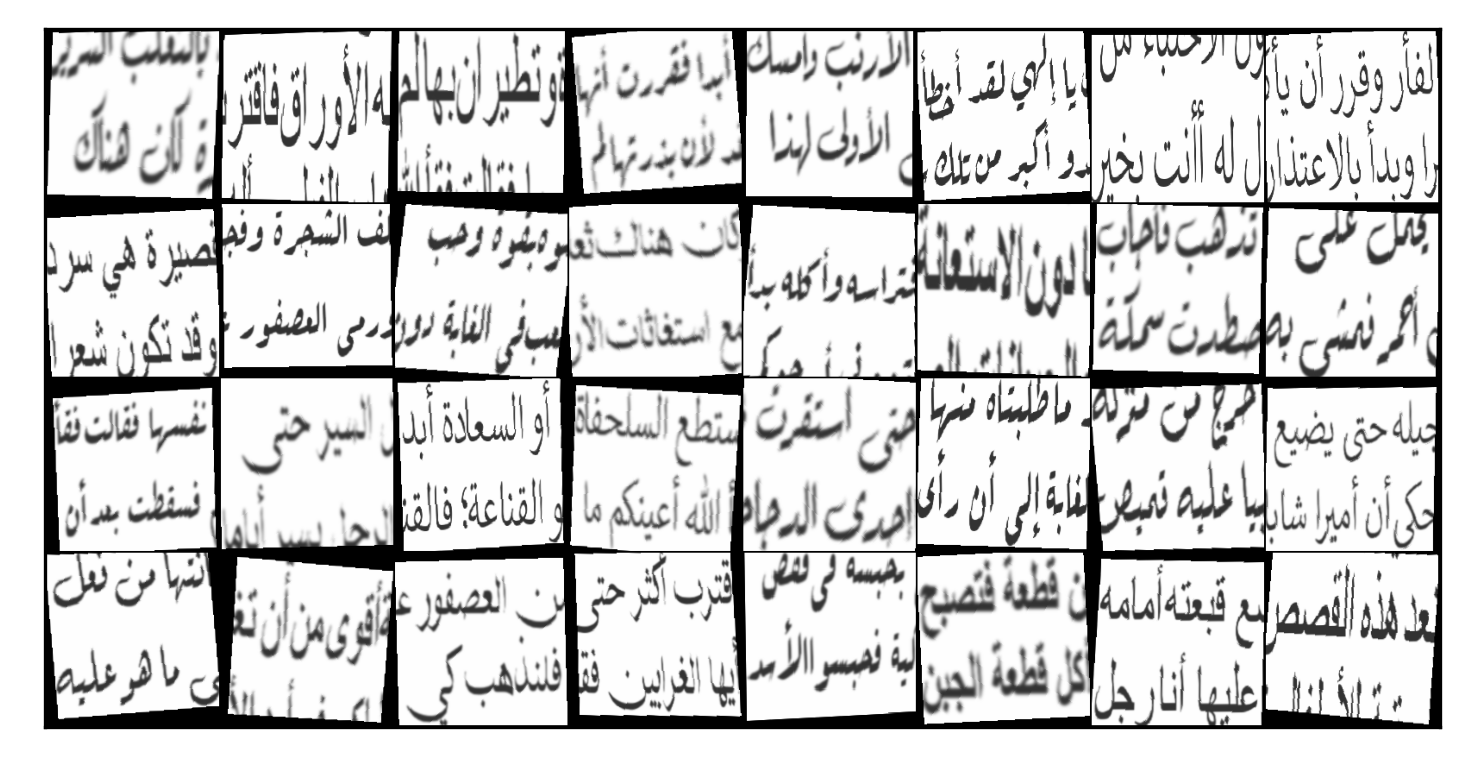

In [16]:
sample, target = next(iter(train_loader))
preds = predict(sample.cuda(), model)
# show(torchvision.utils.make_grid(add_preds_to_images(sample, [classes[label] for label in target], preds)))
show(torchvision.utils.make_grid(sample))

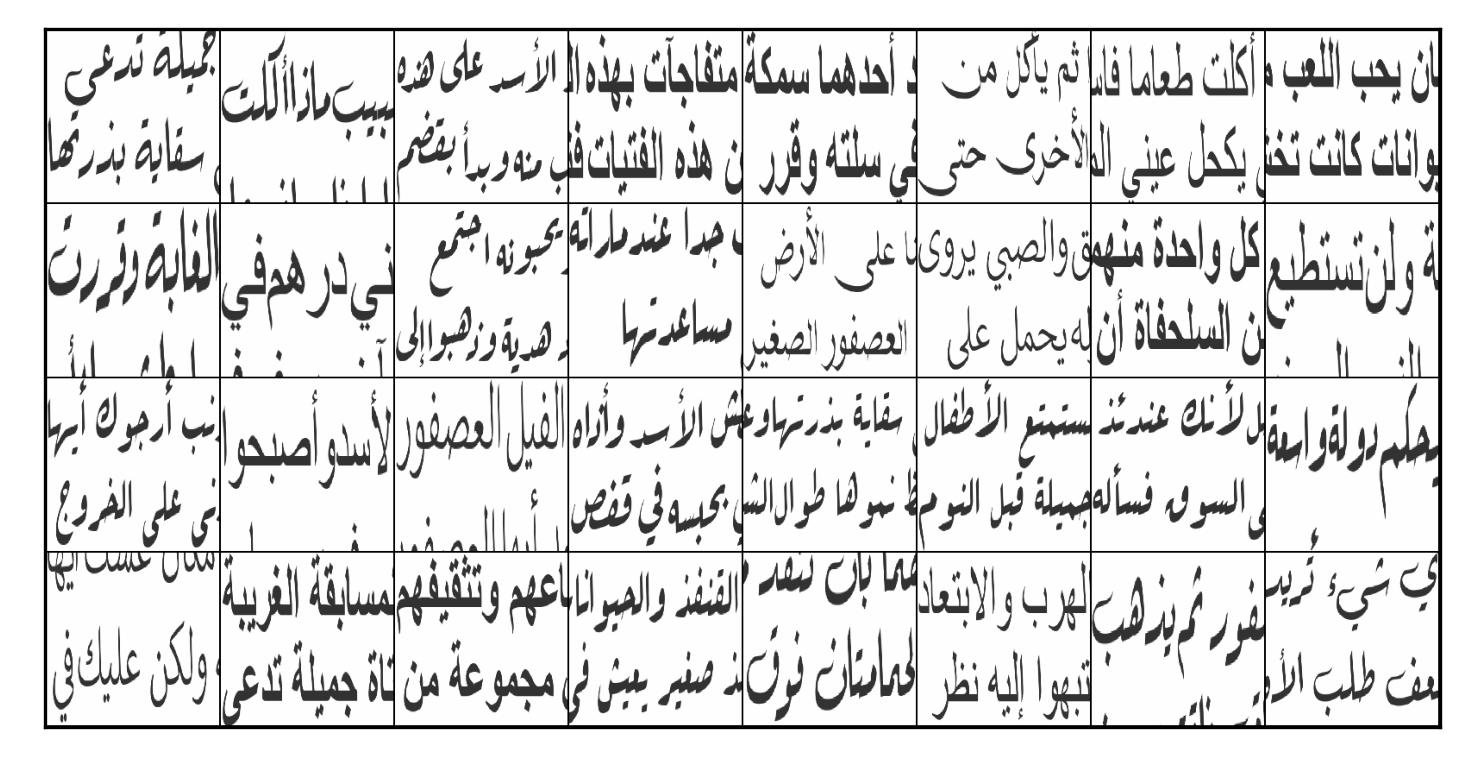

In [17]:
sample, target = next(iter(test_loader))
preds = predict(sample.cuda(), model)
# show(torchvision.utils.make_grid(add_preds_to_images(sample, [classes[label] for label in target], preds)))
show(torchvision.utils.make_grid(sample))

In [18]:
check_accuracy(train_loader, model)
check_accuracy(validation_loader, model)
check_accuracy(test_loader, model)

Got 2084 / 2084 with accuracy 100.00
Got 245 / 245 with accuracy 100.00
Got 123 / 123 with accuracy 100.00


Accuracy (Execluding coffee):  31 /32


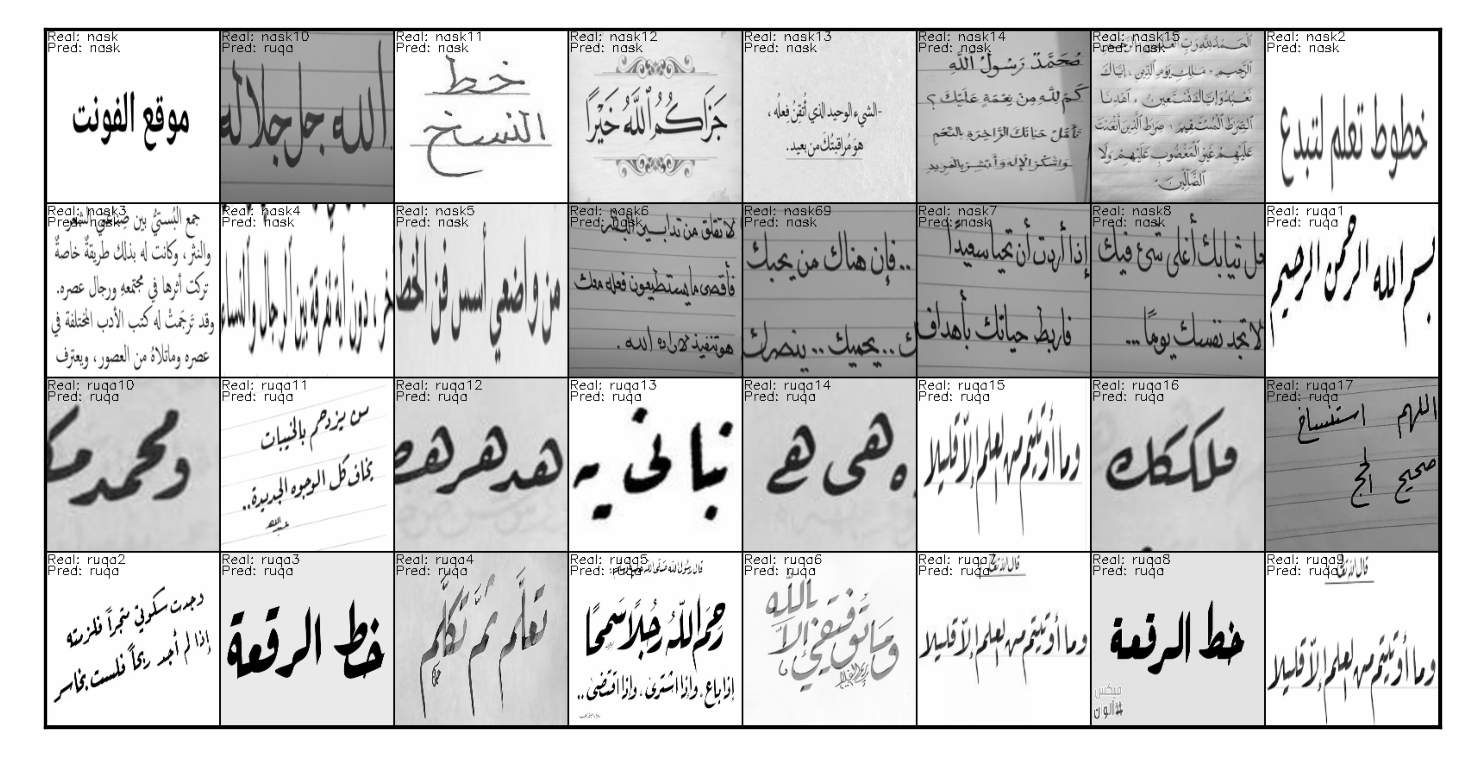

In [13]:
labels = []
images = []
for path in glob("extra_data/extra_test_samples/*"):
    labels.append(path[path.rfind("\\")+1 : path.rfind(".")])
    images.append(transform(cv2.imread(path)))
images = torch.stack(images)
preds = predict(images.cuda(), model.cuda())
show(torchvision.utils.make_grid(add_preds_to_images(images[1:], labels[1:], preds[1:])))
print("Accuracy (Execluding coffee): ", sum(pred in label for label, pred in zip(labels[1:], preds[1:])), f"/{len(preds) - 1}")

### Save & Load with pickle
##### YOU MUST RUN THE CLASS 'NET' CELL AND THE IMPORTS BEFORE EXECUTING A LOAD. PICKLE DOESN'T SAVE CODE, JUST DATA

In [ ]:
torch.save(model, "model.model")

In [10]:
model = torch.load("model.model")

In [5]:
model

Net(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(10, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(30, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(50, 70, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8470, out_features=437, bias=True)
  (fc2): Linear(in_features=437, out_features=109, bias=True)
  (fc3): Linear(in_features=109, out_features=50, bias=True)
  (fc4): Linear(in_features=50, out_features=2, bias=True)
)

In [1]:
transformation

NameError: name 'transformation' is not defined